In [10]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import scipy.stats as stats
from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')

In [11]:
caco3_molar_mass = 100.0869 # g/mol
carbon_molar_mass = 12.011 # g/mol
nitrogen_molar_mass = 14.0067 # g/mol
seconds_per_day = 86400.

# Generate Paths

In [17]:
file_path = '/archive/Lori.Sentman/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond/gfdl.ncrc4-intel18-prod-openmp/pp'
diagType1 = 'ocean_cobalt_fluxes_int'
diagType2 = 'ocean_cobalt_omip_tracers_year_z'

years = ['0481-0485', '0486-0490', '0491-0495', '0496-0500']
yearmons = ['048101-048512', '048601-049012', '049101-049512', '049601-050012']

In [18]:
varlist=['wc_vert_int_jprod_n2amx', 'jprod_nbact_100', 'wc_vert_int_jprod_no3nitrif', 'wc_vert_int_juptake_nh4', 'wc_vert_int_juptake_no3','wc_vert_int_jno3denit']
varlist2=['nh4', 'no3', 'po4']

In [19]:
# using python's list comprehension and path/string join method to put together the appropriate paths
dot = '.'
monthly_file_prefix = os.path.join(file_path, diagType1, 'ts', 'monthly', '5yr/')
monthly_files = [dot.join([monthly_file_prefix + diagType1, ym, v, 'nc']) for v in varlist for ym in yearmons]
#print(monthly_files)

annual_file_prefix = os.path.join(file_path, diagType2, 'ts', 'annual', '5yr/')
annual_files = [dot.join([annual_file_prefix + diagType2, yy, v, 'nc']) for v in varlist2 for yy in years]
#print(annual_files)

In [20]:
grid_file = file_path + '/ocean_annual/ocean_annual.static.nc'
grid = xr.open_dataset(grid_file)

# Read in Data

In [28]:
# monthly 
dsm = xr.open_mfdataset(monthly_files, combine='by_coords')
#dsm = dsm.groupby('time.month').mean(dim='time')

# annual
dsa = xr.open_mfdataset(annual_files, combine='by_coords')

# Plots

In [43]:
totAmx = (dsm.wc_vert_int_jprod_n2amx.mean(dim='time') * grid.areacello).sum(dim=['yh','xh']).values * \
          nitrogen_molar_mass * seconds_per_day * 365 / 1e12
print('Total Anammox water column fixed N removal: ' + str(np.round(totAmx,1)) + ' Tg N')

Total water column fixed N removal: 71.5 Tg N


In [44]:
totDenit = (dsm.wc_vert_int_jno3denit.mean(dim='time') * grid.areacello).sum(dim=['yh','xh']).values * \
          nitrogen_molar_mass * seconds_per_day * 365 / 1e12
print('Total Denitrification fixed N removal: ' + str(np.round(totDenit,1)) + ' Tg N')

Total Denitrification fixed N removal: 69.4 Tg N


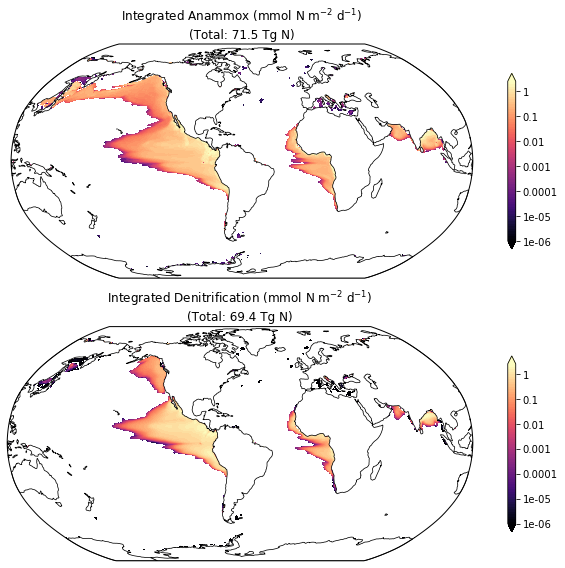

In [74]:
fig=plt.figure(figsize=(10,8))
gs=gridspec.GridSpec(2,1)

ax={};cs={}

fs = 12 #fontsize

###########################################################################
# Anammox                                                                 #
###########################################################################
cmin=-6; cmax=0.5; cint=0.1
levels=np.arange(cmin,cmax,cint)

i=0
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=300.0))
field=np.log10(dsm.wc_vert_int_jprod_n2amx.mean(dim='time')*seconds_per_day*1e3)
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), cmap='magma', levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Integrated Anammox (mmol N m$^{-2}$ d$^{-1}$)\n(Total: '+str(np.round(totAmx,1))+' Tg N)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=np.log10([1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1]), shrink=0.75)
cbar.ax.set_yticklabels([1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1])

###########################################################################
# Denitrification                                                         #
###########################################################################

i=1
ax[i]=plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=300.0))
field=np.log10(dsm.wc_vert_int_jno3denit.mean(dim='time')*seconds_per_day*1e3)
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), cmap='magma', levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Integrated Denitrification (mmol N m$^{-2}$ d$^{-1}$)\n(Total: '+str(np.round(totDenit,1))+' Tg N)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=np.log10([1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1]), shrink=0.75)
cbar.ax.set_yticklabels([1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1])


plt.tight_layout()
fname = 'Anammox_Denitrification'
plt.savefig('../plots_esm42/'+fname+'.png', dpi=300, bbox_inches='tight')

## Bacteria Production

In [45]:
# Total Bacterial Production (g C)
((dc.jprod_nbact_100.mean(dim='time') * grid.areacello).sum(dim=['xh','yh']) * nitrogen_molar_mass * seconds_per_day * 365 * 6.625).values

array(1.0916617e+16, dtype=float32)

Text(0, 0.5, 'Bacteria Production\ntop 100m (g C)')

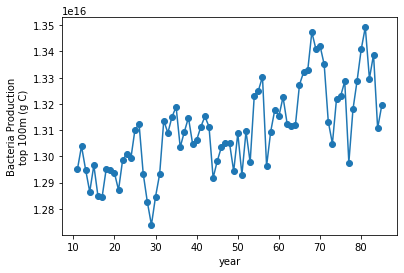

In [46]:
((ds.jprod_nbact_100.groupby('time.year').mean(dim='time')*grid.areacello).sum(dim=['yh','xh']) * nitrogen_molar_mass * seconds_per_day * 365 * 6.625).plot(marker='o')
plt.ylabel('Bacteria Production\ntop 100m (g C)')
#plt.xticks(np.arange(1948,1967,2))

In [80]:
## Bacterial Production from Nitrification
nitrif_ge = 0.004  # 0.4%

In [81]:
val = (dsm.wc_vert_int_jprod_no3nitrif.mean(dim='time') * grid.areacello).sum(dim=['yh','xh']).values * \
nitrogen_molar_mass * seconds_per_day * 365
print('Total water column Nitrification: ' + str(np.format_float_scientific(val,2)) + ' g N')

Total water column Nitrification: 3.1e+15 g N


In [82]:
val = (dsm.wc_vert_int_jprod_no3nitrif.mean(dim='time') * grid.areacello).sum(dim=['yh','xh']).values * \
nitrogen_molar_mass * seconds_per_day * 365 * nitrif_ge * 6.625
print('Total water column nitrifying bacteria production: ' + str(np.format_float_scientific(val,2)) + ' g C')

Total water column nitrifying bacteria production: 8.21e+13 g C


Text(0, 0.5, 'Nitrifying bacteria Production (g C)')

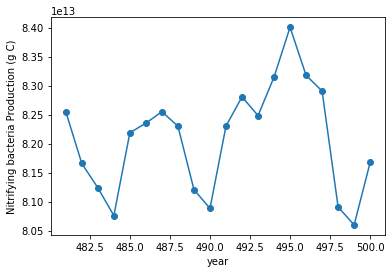

In [83]:
((dsm.wc_vert_int_jprod_no3nitrif.groupby('time.year').mean(dim='time')*grid.areacello).sum(dim=['yh','xh']) * \
 nitrogen_molar_mass * seconds_per_day * 365 * 6.625 * nitrif_ge).plot(marker='o')
plt.ylabel('Nitrifying bacteria Production (g C)')
#plt.xticks(np.arange(1948,1967,2))

Text(0.5, 1.0, 'Nitrifying Bacteria Production (mg C m-2 d-1)')

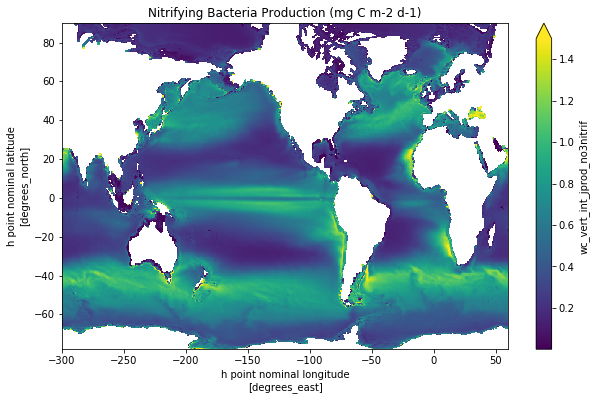

In [84]:
plt.figure(figsize=(10,6))
(dsm.wc_vert_int_jprod_no3nitrif.mean(dim='time')*seconds_per_day*1e3*nitrif_ge*6.625*carbon_molar_mass).plot(cmap='viridis', vmax=1.5)
plt.title('Nitrifying Bacteria Production (mg C m-2 d-1)')

In [85]:
## Bacterial Production from Anammox
amx_ge = 0.01 # 1% yield

val = (dsm.wc_vert_int_jprod_n2amx.mean(dim='time') * grid.areacello).sum(dim=['yh','xh']).values * \
nitrogen_molar_mass * seconds_per_day * 365 * amx_ge * 6.625
print('Total water column anammox bacteria production: ' + str(np.format_float_scientific(val,2)) + ' g C')

Total water column anammox bacteria production: 4.74e+12 g C


In [86]:
no3_2_n2_amx = (106.0*3.0*3.0*5.0-118.0*4.0)/(106.0*3.0*4.0*5.0-118.0*2.0)
nh4_2_n2_amx = (16.0+106.0*3.0*5.0*5.0)/(106.0*3.0*4.0*5.0-118.0*2.0)
amx_ge = 0.01

In [87]:
# the N in amx bacteria comes from the NH4 portion of the reaction
val = (dsm.wc_vert_int_jprod_n2amx * grid.areacello).sum(dim=['yh','xh']).mean(dim='time').values * \
nitrogen_molar_mass * seconds_per_day * 365
val = val / (no3_2_n2_amx + nh4_2_n2_amx) * nh4_2_n2_amx * amx_ge * 6.625
print('Total water column anammox bacteria production: ' + str(np.format_float_scientific(val,2)) + ' g C')

Total water column anammox bacteria production: 3.08e+12 g C


In [89]:
nitbact=dsm.wc_vert_int_jprod_no3nitrif.mean(dim='time')*nitrif_ge
amxbact=dsm.wc_vert_int_jprod_n2amx.mean(dim='time') / (no3_2_n2_amx + nh4_2_n2_amx) * nh4_2_n2_amx * amx_ge
totalbact=dsm.jprod_nbact_100.mean(dim='time')

In [93]:
dsm.jprod_nbact_100

<xarray.DataArray 'jprod_nbact_100' (time: 240, yh: 576, xh: 720)>
dask.array<concatenate, shape=(240, 576, 720), dtype=float32, chunksize=(60, 576, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0481-01-16 12:00:00 ... 0500-12-16 12:00:00
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
Attributes:
    units:          mol m-2 s-1
    long_name:      Bacteria nitrogen prod. integral in upper 100m
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT

Text(0.5, 1.0, 'water column nitrifying + anammox bacteria / top 100 m bacteria production')

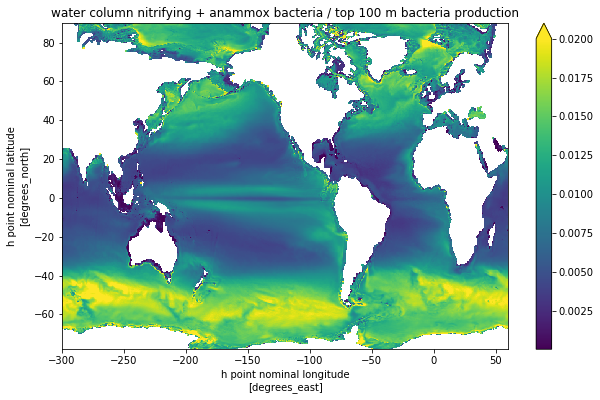

In [90]:
plt.figure(figsize=(10,6))

((nitbact+amxbact)/totalbact).plot(vmax=0.02)
plt.title('water column nitrifying + anammox bacteria / top 100 m bacteria production')

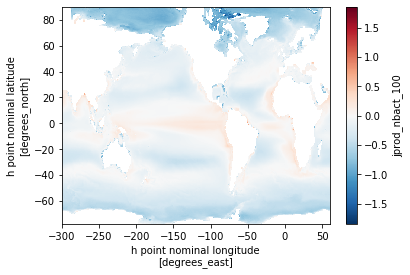

In [101]:
np.log10(totalbact*seconds_per_day*1e3).plot()

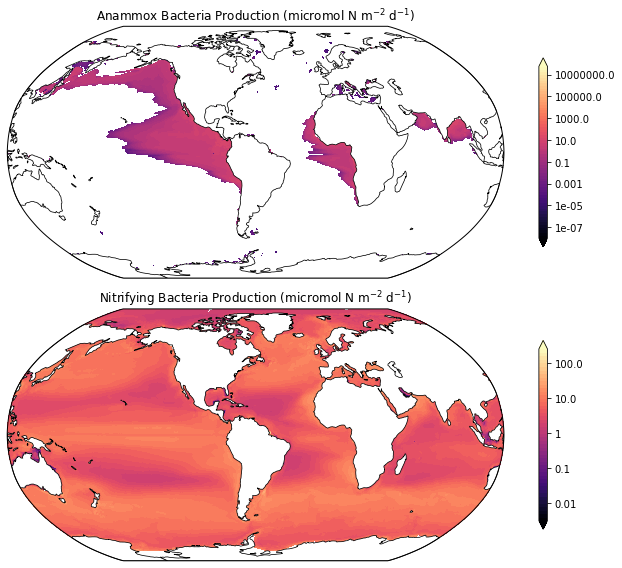

In [99]:
fig=plt.figure(figsize=(10,8))
gs=gridspec.GridSpec(2,1)

ax={};cs={}

fs = 12 #fontsize

###########################################################################
# Anammox                                                                 #
###########################################################################
cmin=-1.75; cmax=1.75; cint=0.1
levels=np.arange(cmin,cmax,cint)

i=0
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=300.0))
field=np.log10(amxbact*seconds_per_day*1e6)
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), cmap='magma', levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Anammox Bacteria Production (micromol N m$^{-2}$ d$^{-1}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=np.log10([-0.03,-0.01,0,]), shrink=0.75)
cbar.ax.set_yticklabels([1e-7, 1e-5, 1e-3, 1e-1, 1e1, 1e3, 1e5, 1e7])

###########################################################################
# Nitrif                                                         #
###########################################################################
cmin=-2.5; cmax=2.5; cint=0.1
levels=np.arange(cmin,cmax,cint)

i=1
ax[i]=plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=300.0))
field=np.log10(nitbact*seconds_per_day*1e6)
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), cmap='magma', levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Nitrifying Bacteria Production (micromol N m$^{-2}$ d$^{-1}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=np.log10([1e-2, 1e-1, 1, 1e1, 1e2]), shrink=0.75)
cbar.ax.set_yticklabels([1e-2, 1e-1, 1, 1e1, 1e2])


plt.tight_layout()
#fname = 'Amx_Nitrif_Bact'
#plt.savefig('../plots_esm42/'+fname+'.png', dpi=300, bbox_inches='tight')

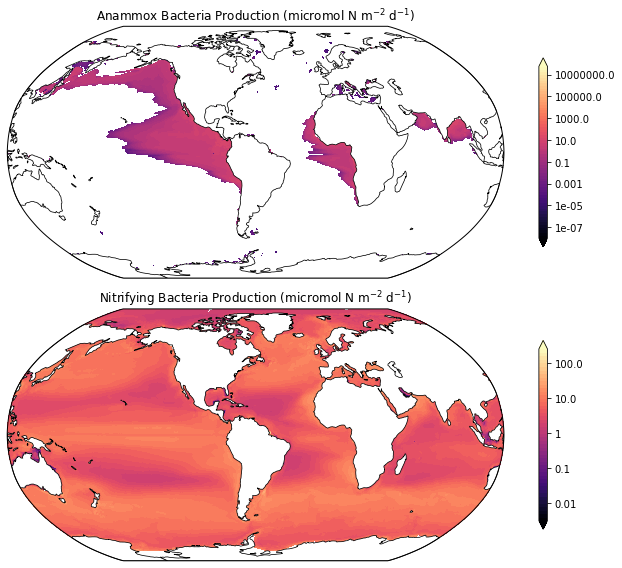

In [99]:
fig=plt.figure(figsize=(10,8))
gs=gridspec.GridSpec(2,1)

ax={};cs={}

fs = 12 #fontsize

###########################################################################
# Anammox                                                                 #
###########################################################################
cmin=-8; cmax=8; cint=0.25
levels=np.arange(cmin,cmax,cint)

i=0
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=300.0))
field=np.log10(totbact*seconds_per_day*1e3)
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), cmap='magma', levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Total Bacteria Production (mmol N m$^{-2}$ d$^{-1}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=np.log10([1e-7, 1e-5, 1e-3, 1e-1, 1e1, 1e3, 1e5, 1e7]), shrink=0.75)
cbar.ax.set_yticklabels([1e-7, 1e-5, 1e-3, 1e-1, 1e1, 1e3, 1e5, 1e7])

###########################################################################
# Nitrif                                                         #
###########################################################################
cmin=-2.5; cmax=2.5; cint=0.1
levels=np.arange(cmin,cmax,cint)

i=1
ax[i]=plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=300.0))
field=np.log10(nitbact*seconds_per_day*1e6)
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), cmap='magma', levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Nitrifying Bacteria Production (micromol N m$^{-2}$ d$^{-1}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=np.log10([1e-2, 1e-1, 1, 1e1, 1e2]), shrink=0.75)
cbar.ax.set_yticklabels([1e-2, 1e-1, 1, 1e1, 1e2])


plt.tight_layout()
fname = 'Amx_Nitrif_Bact'
plt.savefig('../plots_esm42/'+fname+'.png', dpi=300, bbox_inches='tight')

## Comparisons with Observations - NH4

In [50]:
# Fabien's NH4 profiles
#nh4_prof = xr.open_dataset('/archive/Fabien.Paulot/fp_analysis/data/Ocean/Seawater/nhx_sw_summary_201912.nc')
nh4_prof = xr.open_dataset('/work/jyl/proj/ESM4.2_COBALT/anammox_parameterization/notebooks/other_data/nhx_sw_summary_201912.nc')
nh4_prof.obs

<xarray.DataArray 'obs' (time: 251566)>
[251566 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2017-01-16T17:40:18.750000128 ... 2003-05-27
Attributes:
    pressure:  204.0
    units:     umol/L
    LFM:       302
    ABS:       -1.0
    MAX:       0.29
    MIN:       0.08

In [51]:
import pandas as pd
data = {'time':nh4_prof.time.values,
        'lat':nh4_prof.lat.values, 
        'lon':nh4_prof.lon.values,
        'mission_id':nh4_prof.mission_id.values,
        'depth':nh4_prof.depth.values,
        'obs':nh4_prof.obs.values}
df = pd.DataFrame(data)

In [52]:
df['depth'] = df['depth'].map(lambda depth: np.round(depth * 2.) / 2.)
df['time'] = df.time.values.astype('datetime64[s]').tolist()
df

,time,lat,lon,mission_id,depth,obs
0,2017-01-16 17:40:18,-77.732803,177.990707,16.0,101.5,0.90045
1,2017-01-16 17:40:18,-77.732803,177.990707,16.0,76.0,0.86940
2,2017-01-16 17:40:18,-77.732803,177.990707,16.0,35.5,0.80730
3,2017-01-16 17:40:18,-77.732803,177.990707,16.0,2.0,0.63135
4,2017-01-16 06:45:00,-75.987503,-178.900101,16.0,46.0,0.64170
...,...,...,...,...,...,...
251561,2003-05-27 00:00:00,-9.510410,-25.000050,158.0,150.5,0.21000
251562,2003-05-27 00:00:00,-9.510410,-25.000050,158.0,174.5,0.14000
251563,2003-05-27 00:00:00,-9.510410,-25.000050,158.0,200.0,0.15000
251564,2003-05-27 00:00:00,-9.510410,-25.000050,158.0,250.5,0.22000


In [55]:
nh4_amx = dsa.nh4
nh4_amx = nh4_amx.assign_coords(xh=(((nh4_amx.xh + 180) % 360) - 180))
nh4_amx = nh4_amx.sortby(nh4_amx.xh)
nh4_amx.values = nh4_amx.values * 1e3
nh4_amx.attrs['units'] = 'mmol m-3'


In [56]:
dfcopy = df.loc[(df.lat <= 20) & (df.lat >= -20) & (df.lon < -70) & (df.lon >= -100)]
#dfcopy = dfcopy.loc[(dfcopy.mission_id != 59.)]
dfcopy['month'] = pd.DatetimeIndex(dfcopy.time).month
dfcopy

,time,lat,lon,mission_id,depth,obs,month
64112,2011-04-14 17:03:45,-13.319400,-96.476799,5.0,2.0,0.018425,4
64113,2011-04-14 22:52:30,-12.966200,-96.092102,5.0,0.0,0.018425,4
64114,2011-04-14 23:03:45,-12.975300,-96.073601,5.0,2.0,0.018425,4
64115,2011-04-15 01:18:45,-13.003100,-96.009499,5.0,5.0,0.018425,4
64116,2011-04-15 01:18:45,-13.003100,-96.009499,5.0,5.0,0.018425,4
...,...,...,...,...,...,...,...
184410,1986-08-31 16:28:35,-3.925000,-87.691666,59.0,0.0,0.100000,8
184411,1986-09-01 02:20:37,-3.226667,-88.410004,59.0,0.0,0.750000,9
184412,1986-09-01 10:46:52,-2.533333,-89.128334,59.0,0.0,0.140000,9
184413,1986-09-05 22:35:37,-0.911667,-90.366669,59.0,0.0,0.120000,9


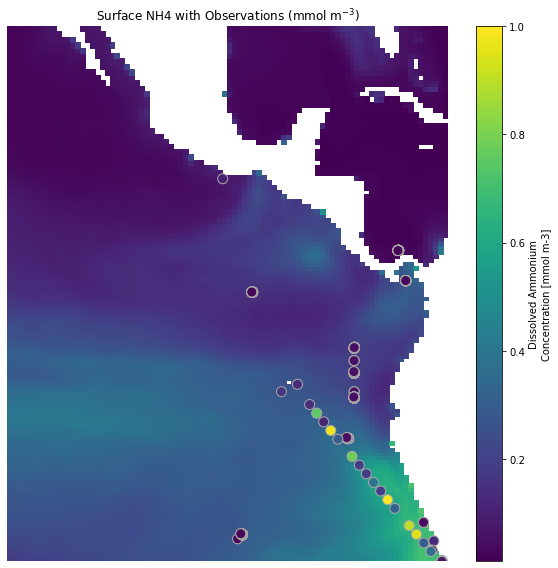

In [75]:
plt.figure(figsize=(8,8))

nh4_amx.sel(yh=slice(-15,28), xh=slice(-120,-75)).isel(z_l=0,time=3).plot(vmax=1)
plt.scatter(x=dfcopy.loc[df.depth <= 10].lon, y=dfcopy.loc[df.depth <= 10].lat, c=dfcopy.loc[df.depth <= 10].obs, edgecolor='darkgrey', s=100, vmax=1, vmin=0)
plt.title('Surface NH4 with Observations (mmol m$^{-3}$)')
# plt.tick_params(
#     axis='both',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False, # labels along the bottom edge are off
#     left=False,
#     right=False,
#     labelleft=False)
plt.axis('off')

plt.tight_layout()
fname = 'ETP_SurfaceNH4'
plt.savefig('../plots_esm42/'+fname+'.png', dpi=300, bbox_inches='tight')


In [58]:
df_DJF = dfcopy.loc[(dfcopy.month == 12) | (dfcopy.month == 1) | (dfcopy.month == 2)]
df_MAM = dfcopy.loc[(dfcopy.month == 3) | (dfcopy.month == 4) | (dfcopy.month == 5)]
df_JJA = dfcopy.loc[(dfcopy.month == 6) | (dfcopy.month == 7) | (dfcopy.month == 8)]
df_SON = dfcopy.loc[(dfcopy.month == 9) | (dfcopy.month == 10) | (dfcopy.month == 11)]

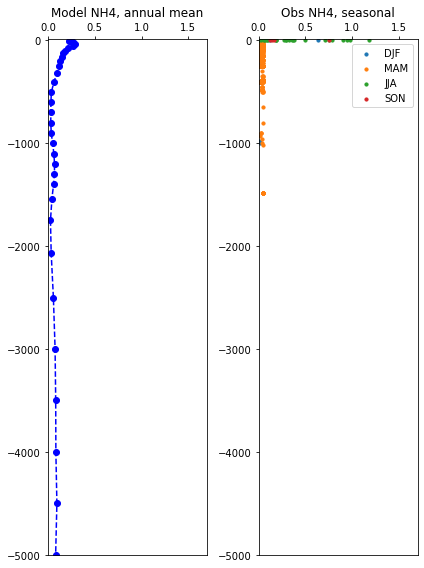

In [79]:
fig, axs = plt.subplots(1,2, figsize=(6,8))

# y1=nh4_ctrl.sel(yh=slice(-15,28), xh=slice(-120,-75)).mean(dim=['xh','yh']).mean(dim='time').z_l.values
# x1=nh4_ctrl.sel(yh=slice(-15,28), xh=slice(-120,-75)).mean(dim=['xh','yh']).mean(dim='time').values

y2=nh4_amx.sel(yh=slice(-15,28), xh=slice(-120,-75)).mean(dim=['xh','yh']).mean(dim='time').z_l.values
x2=nh4_amx.sel(yh=slice(-15,28), xh=slice(-120,-75)).mean(dim=['xh','yh']).mean(dim='time').values

#axs[0].plot(x1,-y1,'bo-')
axs[0].plot(x2,-y2,'bo--')
axs[0].set_xlim(0,1.7)
axs[0].set_ylim(-5000,10)
axs[0].xaxis.set_ticks_position('top')
#axs[0].legend(['Anammox','Obs'])
axs[0].set_title('Model NH4, annual mean')

markersize=10
axs[1].scatter(df_DJF.obs, -1* df_DJF.depth, s=markersize)
axs[1].scatter(df_MAM.obs, -1* df_MAM.depth, s=markersize)
axs[1].scatter(df_JJA.obs, -1* df_JJA.depth, s=markersize)
axs[1].scatter(df_SON.obs, -1* df_SON.depth, s=markersize)
axs[1].set_xlim(0,1.7)
axs[1].set_ylim(-5000,10)
axs[1].xaxis.set_ticks_position('top')
axs[1].legend(['DJF','MAM','JJA','SON'])
axs[1].set_title('Obs NH4, seasonal')

plt.tight_layout()
fname = 'ETP_NH4profile'
plt.savefig('../plots_esm42/'+fname+'.png', dpi=300, bbox_inches='tight')

## N* analysis

In [77]:
ds_nstar = dsa.no3 - 16.0 * dsa.po4 + (2.9 * 1e-3) # mol/m3
dc_nstar = dca.no3 - 16.0 * dca.po4 + (2.9 * 1e-3) # mol/m3

In [78]:
ds_nstar.compute()
dc_nstar.compute()

<xarray.DataArray (time: 75, z_l: 35, yh: 576, xh: 720)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * time     (time) object 0011-07-02 12:00:00 ... 0085-07-02 12:00:00
  * xh       (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh       (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03

Text(0.5, 1.0, 'N* surface, AmxNitrif Model')

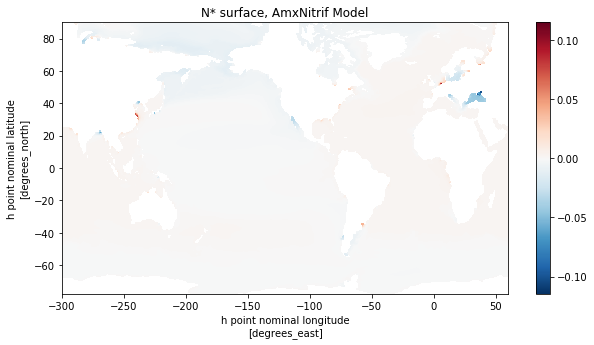

In [79]:
plt.figure(figsize=(10,5))
ds_nstar.mean(dim='time').isel(z_l=0).plot()
plt.title('N* surface, AmxNitrif Model')

Text(0.5, 1.0, 'N* surface, Control Model')

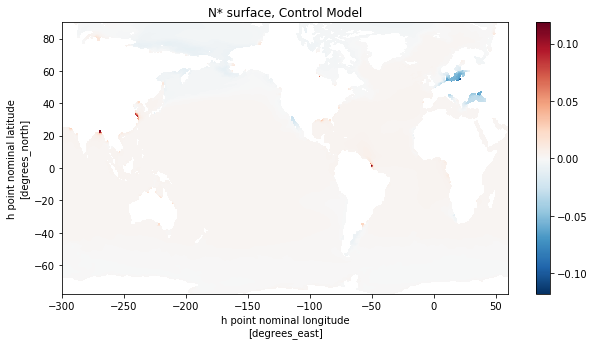

In [80]:
plt.figure(figsize=(10,5))
dc_nstar.mean(dim='time').isel(z_l=0).plot()
plt.title('N* surface, Control Model')

Text(0, 0.5, '')

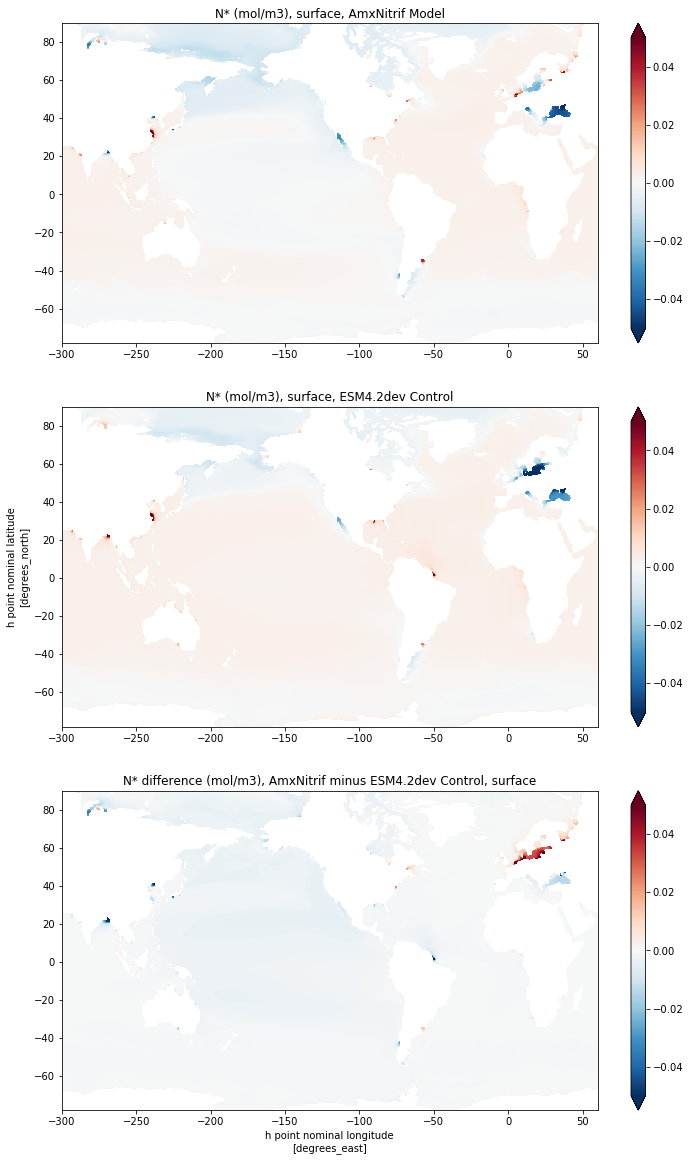

In [81]:
fig, axs = plt.subplots(3, figsize=(12,20))

ds_nstar.mean(dim='time').isel(z_l=0).plot(ax=axs[0], vmax=-0.05,vmin=0.05,cmap='RdBu_r')
axs[0].set_title('N* (mol/m3), surface, AmxNitrif Model')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

dc_nstar.mean(dim='time').isel(z_l=0).plot(ax=axs[1], vmax=-0.05,vmin=0.05,cmap='RdBu_r')
axs[1].set_title('N* (mol/m3), surface, ESM4.2dev Control')
axs[1].set_xlabel('')

(ds_nstar.mean(dim='time') - dc_nstar.mean(dim='time')).isel(z_l=0).plot(ax=axs[2],vmax=-0.05,vmin=0.05,cmap='RdBu_r')
axs[2].set_title('N* difference (mol/m3), AmxNitrif minus ESM4.2dev Control, surface')
axs[2].set_ylabel('')

In [82]:
layer_depth=dsa.z_i.isel(z_i=slice(10,14)).values[-1]-dsa.z_i.isel(z_i=slice(10,14)).values[0]

ds_nstar_225450=(ds_nstar.mean(dim='time') * np.diff(dsa.z_i)[:,np.newaxis,np.newaxis]).isel(z_l=slice(10,13)).sum(dim='z_l')/layer_depth
dc_nstar_225450=(dc_nstar.mean(dim='time') * np.diff(dca.z_i)[:,np.newaxis,np.newaxis]).isel(z_l=slice(10,13)).sum(dim='z_l')/layer_depth

Text(0, 0.5, '')

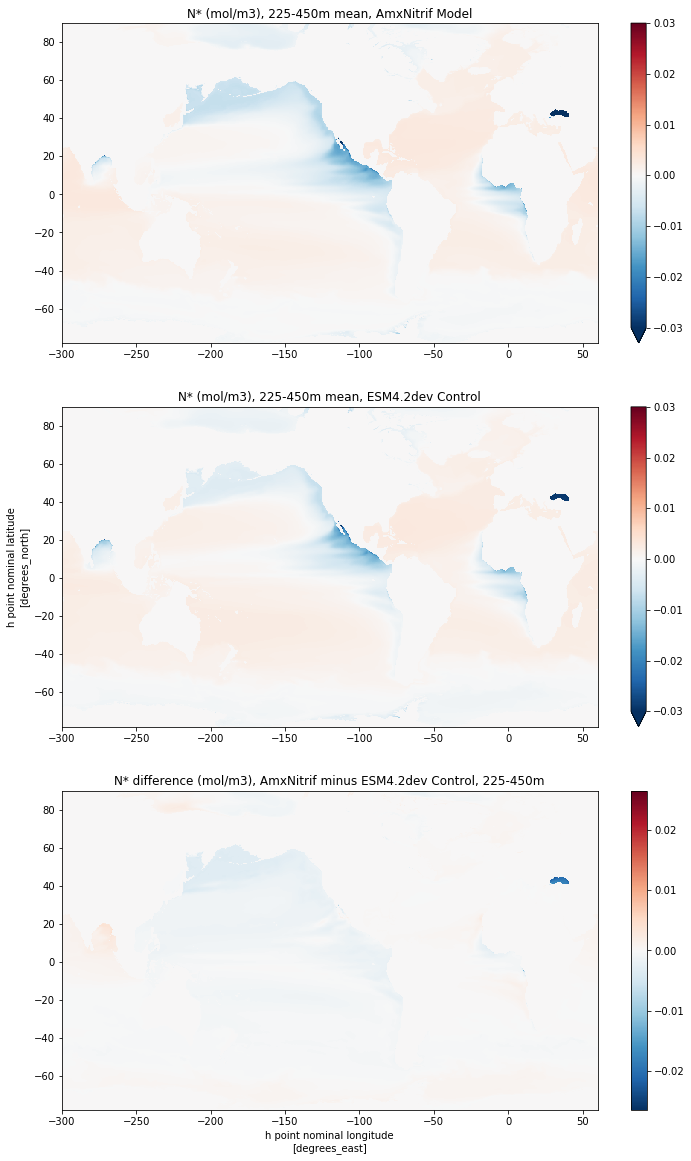

In [83]:
fig, axs = plt.subplots(3, figsize=(12,20))

ds_nstar_225450.plot(ax=axs[0], vmin=-0.03,vmax=0.03, cmap='RdBu_r')
axs[0].set_title('N* (mol/m3), 225-450m mean, AmxNitrif Model')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

dc_nstar_225450.plot(ax=axs[1], vmin=-0.03,vmax=0.03, cmap='RdBu_r')
axs[1].set_title('N* (mol/m3), 225-450m mean, ESM4.2dev Control')
axs[1].set_xlabel('')

(ds_nstar_225450 - dc_nstar_225450).plot(ax=axs[2], cmap='RdBu_r')
axs[2].set_title('N* difference (mol/m3), AmxNitrif minus ESM4.2dev Control, 225-450m')
axs[2].set_ylabel('')